# NLP/Decision Tree Extension Project

Extension Project on Decision Trees and . Explanations of relevant graphs and their analyses are in the report.

Note: This notebook was curated for use with the final report as a more polished combination/distillation of our work. Some less interesting or important analysis is left out for brevity, but is available in the original project notebooks.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option('display.max_columns', 100)
nltk.download('stopwords')

# from google.colab import drive
# drive.mount('/content/drive')

# estimated runtime ~ 1.5 minutes

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
abp_df = pd.read_csv("../data/cleaned_abp.csv")
abp_df.head(2)

,id,permit,class,type,description,text,value,fee,status,occupancytype,sqft,city,zipcode,lat,lon,year,month,day,end_year,end_month,end_day
0,1,1000569,INTEXT,Amendment to a Long Form,Interior/Exterior Work,this work is to amend permit alt eliminate con...,36500.0,390.0,Open,Mixed,0.0,Boston,2109.0,42.35919,-71.052924,2021,1,28,2021.0,7.0,28.0
1,2,100071,COB,Amendment to a Long Form,City of Boston,change connector link layout from attached enc...,40000.0,429.0,Open,Comm,170.0,West Roxbury,2132.0,42.26075,-71.149611,2011,11,4,2012.0,5.0,4.0


In [28]:
zba_df = pd.read_csv('../data/cleaned_zba.csv')
zba_df.head(2)

,status,parent_apno,boa_apno,appeal_type,deferrals,decision,city,zipcode,ward,zoning_district,text,year,month,day,hearing_submitted,final_submitted,final_hearing,closed_submitted,closed_final,closed_hearing
0,1,NaN,1534017,0,NaN,NaN,Jamaica Plain,2130,19,Jamaica Plain,NaN,2023,10,7,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,1534015,0,NaN,NaN,Roslindale,2131,19,Jamaica Plain,NaN,2023,10,7,NaN,NaN,NaN,NaN,NaN,NaN


### Initial Analyses

First let us merge the zba and abp data

In [29]:
abp = abp_df.copy()
zba = zba_df.copy()

abp['Approved'] = 1
zba['Approved'] = 0

temp_a = abp[['id','city', 'zipcode', 'text', 'Approved']]
temp_z = zba[['boa_apno', 'city', 'zipcode', 'text', 'Approved']]

temp_z.rename(columns={'boa_apno': 'id'}, inplace=True)

df = pd.concat([temp_a, temp_z], ignore_index=True)
df.sample(3)

C:\Users\lukas\AppData\Local\Temp\ipykernel_21664\3799211549.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_z.rename(columns={'boa_apno': 'id'}, inplace=True)


,id,city,zipcode,text,Approved
607051,607048,Mattapan,2126.0,install windows replace porch railings scrape...,1
555379,555368,Dorchester,2125.0,remove non structural cmu walls and drywall pa...,1
416244,416221,Boston,2116.0,new kitchen equipment,1


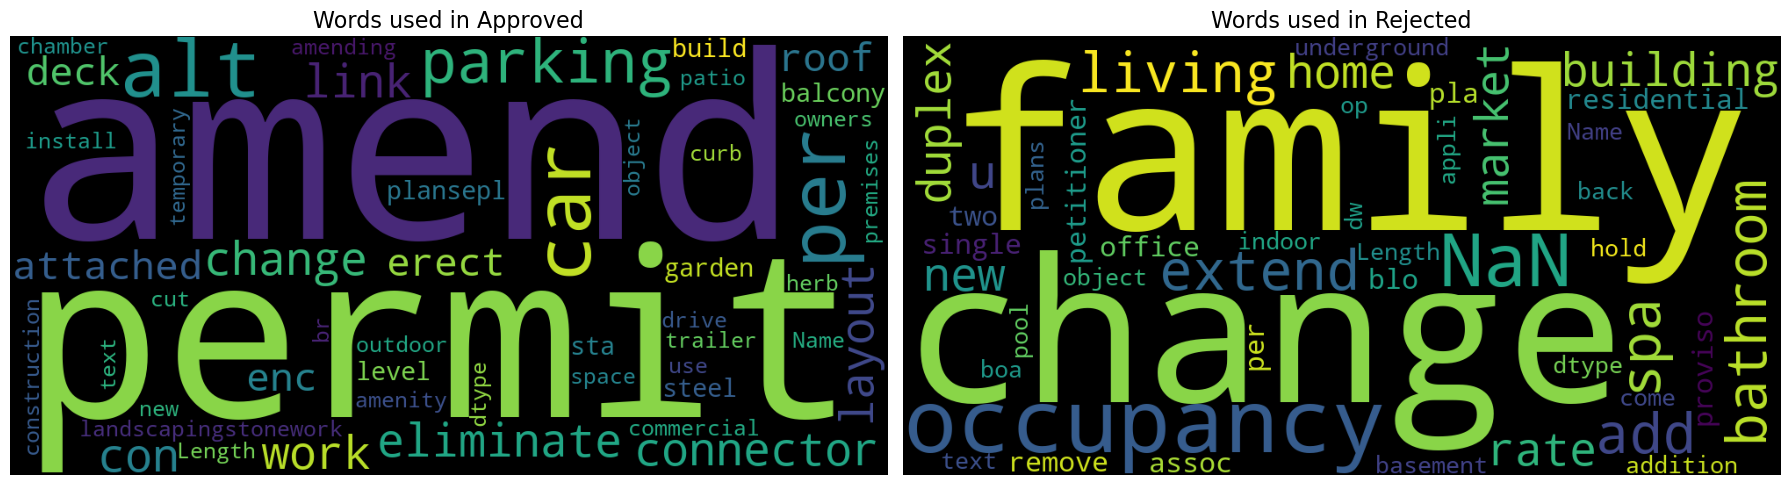

In [30]:
words_summary = pd.Series(' '.join(str(df.loc[df.Approved==1]['text']).split()))
wordcloud_summary = WordCloud(width = 1000, height = 500).generate(' '.join(words_summary))

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.imshow(wordcloud_summary)
plt.title("Words used in Approved", size=16)
plt.axis("off")

words_summary = pd.Series(' '.join(str(df.loc[df.Approved==0]['text']).split()))
wordcloud_summary = WordCloud(width = 1000, height = 500).generate(' '.join(words_summary))

plt.subplot(1,2,2)
plt.imshow(wordcloud_summary)
plt.title("Words used in Rejected", size=16)
plt.axis("off")

plt.tight_layout()
plt.show()

Now let's check if the zipcode and city data will be helpful for our decision trees. Spoiler - its not.

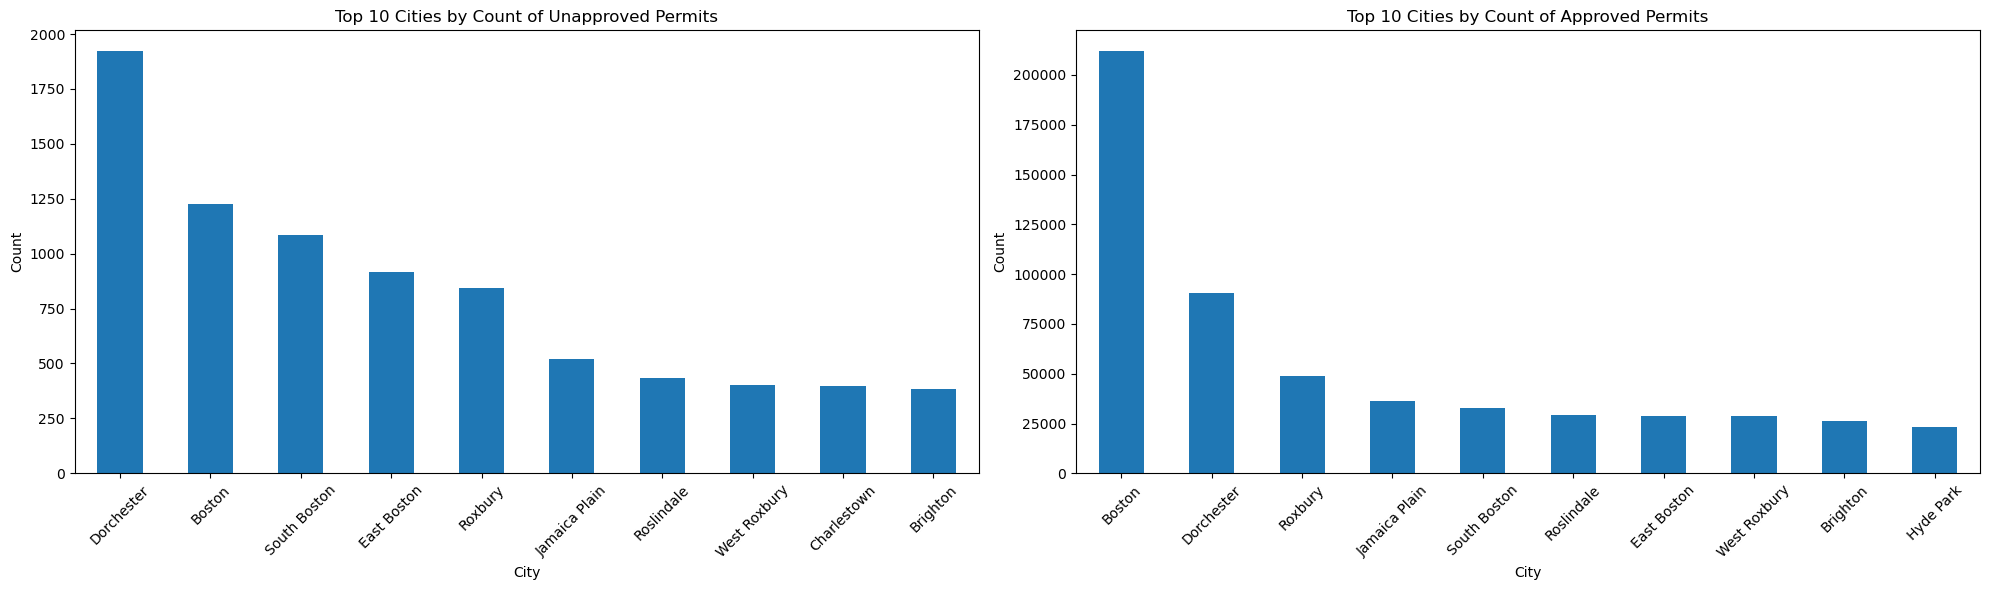

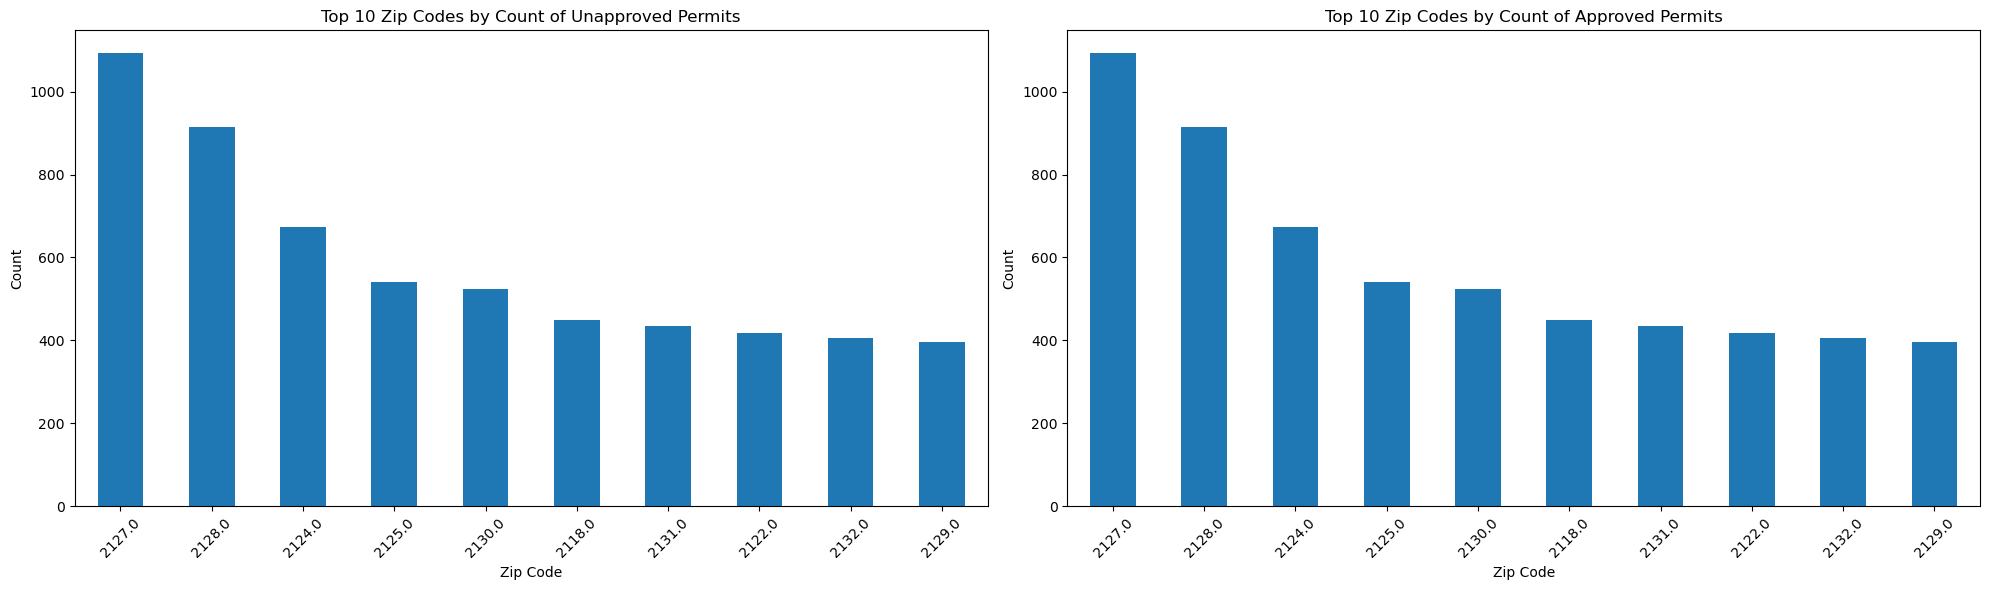

In [31]:
## Cities =================================================================
count_data = df.loc[df.Approved == 0].groupby('city')['id'].count().nlargest(10)

plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
count_data.plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Top 10 Cities by Count of Unapproved Permits')
plt.xticks(rotation=45)

count_data = df.loc[df.Approved == 1].groupby('city')['id'].count().nlargest(10)

plt.subplot(1,2,2)
count_data.plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Top 10 Cities by Count of Approved Permits')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Zipcodes =================================================================
count_data = df.loc[df.Approved == 0].groupby('zipcode')['id'].count().nlargest(10)

plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
count_data.plot(kind='bar')
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.title('Top 10 Zip Codes by Count of Unapproved Permits')
plt.xticks(rotation=45)

count_data2 = df.loc[df.Approved == 1].groupby('zipcode')['id'].count().nlargest(10)

plt.subplot(1,2,2)
count_data.plot(kind='bar')
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.title('Top 10 Zip Codes by Count of Approved Permits')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Decision Tree

Since the ZBA dataset is significantly smaller than the abp dataset, it means the number of approved permits vastly outnumbers the number of initially denied permits and certainly the number of zba denied permits. To circumvent this, we will initially interpret the zba dataset as denied permits and then randomly sample the abp dataset to ensure the decision trees we generate are balanced. We will also make sure our data is from the same time frame. Our final data should be around 16000 minimum entries. 

In [32]:
zba_df = zba_df[['parent_apno','appeal_type', 'decision', 'city', 'zipcode', 'ward', 'zoning_district', 'text', 'year', 'month', 'day', 'hearing_submitted']]
abp_df = abp_df[['permit', 'class', 'type', 'description', 'text', 'value', 'fee', 'status', 'occupancytype', 'sqft', 'city', 'zipcode', 'lat', 'lon', 'year', 'month', 'day']]

apnos = list(zba_df['parent_apno']) # to ensure no approved values that went through zba

# filter out unwanted rows and get text columns
zba_temp = zba_df[zba_df['year'] > 2014] # match min date to abp
zba_temp = pd.DataFrame({'text': zba_temp['text'], 'approved': False})

abp_temp = abp_df[~abp_df['permit'].isin(apnos)]
abp_temp = abp_temp.sample(n=9000, random_state=42) # sample to get balanced data
abp_temp = pd.DataFrame({'text': abp_temp['text'], 'approved': True})

merged_df = pd.concat([abp_temp, zba_temp], ignore_index=True)


Next we can take our merged dataset and remove stopwords

In [33]:
# Tokenize the string into words
def remove_stopwords(sample_string):
    sample_string = str(sample_string)
    # if np.isnan(sample_string):
    #     return ''
    words = word_tokenize(sample_string)
    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
    return ' '.join(filtered_words)

merged_df.text = merged_df.text.apply(remove_stopwords)
merged_df.sample()

,text,approved
9084,adding space th floor deck modification clarif...,False


Finally let's train our decision tree

Accuracy: 0.79
              precision    recall  f1-score   support

       False       0.92      0.61      0.73      1598
        True       0.73      0.95      0.83      1810

    accuracy                           0.79      3408
   macro avg       0.83      0.78      0.78      3408
weighted avg       0.82      0.79      0.78      3408



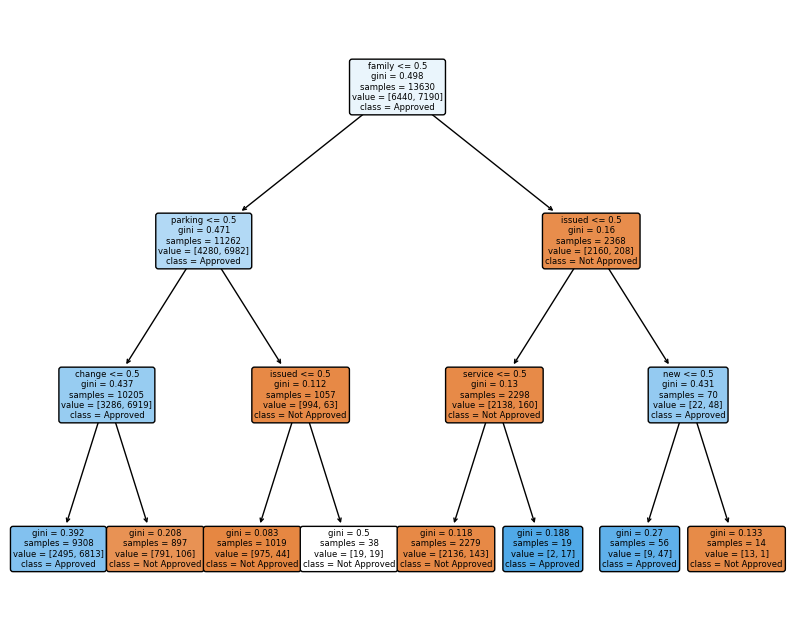

In [34]:
X_train, X_test, y_train, y_test = train_test_split(merged_df['text'], merged_df['approved'], test_size=0.2, random_state=42)

# Vectorize the text data (convert text into numerical features)
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


model = DecisionTreeClassifier(max_depth = 3, random_state=52)
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_test_vectorized)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
plot_tree(model, filled=True, feature_names=list(vectorizer.get_feature_names_out()), class_names=['Not Approved', 'Approved'], rounded=True)
plt.show()